# Circuito cuántico para predecir

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.circuit import Parameter, ParameterVector
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Inicialziqamos las carácteristicas de nuestro circuito cuántico y de nuestro conjunto de datos de manera aleatoria 

In [2]:
n=3
num_layers = 2
params = np.random.random(n*(num_layers+1))

In [3]:
k = 100

y_train = np.random.random(k)
x_train =[]
for i in range(k):
    x_train.append(np.random.random(n))
x_train[0]

array([0.99682937, 0.85265945, 0.60346763])

In [4]:
def vqc(n, num_layers,inputs,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    inputs_parameters = ParameterVector('input', n)
    
    parameters = ParameterVector('θ', n*(num_layers+1))


    circuit = QuantumCircuit(n, 1)
    
    for inp in range(n):
        #Appending the parameterized Ry gates using parameters from the vector constructed above
        circuit.ry(inputs_parameters[inp], inp)
    circuit.barrier()
        
    for i in range(n):
        circuit.h(i)
    circuit.barrier()
    
    for layer in range(num_layers):
        #Appending the parameterized Ry gates using parameters from the vector constructed above
        for i in range(n):
            circuit.rz(parameters[n*layer+i], i)
        circuit.barrier()

        #Appending the entangling CNOT gates
        for i in range(n-1):
            #for j in range(i):
            circuit.cz(i,2)
        circuit.barrier()

    #Appending one additional layer of parameterized Ry gates
    for i in range(n):
        circuit.rz(parameters[n*num_layers+i], i)
    circuit.barrier()
    
    for i in range(n):
        circuit.h(i)
    circuit.barrier()
    
    inputs_dict = {}
    i = 0
    for p in inputs_parameters:
        inputs_dict[p] = inputs[i]
        i += 1 
    
    
    params_dict = {}
    i = 0
    for p in parameters:
        params_dict[p] = params[i]
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = inputs_dict)
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

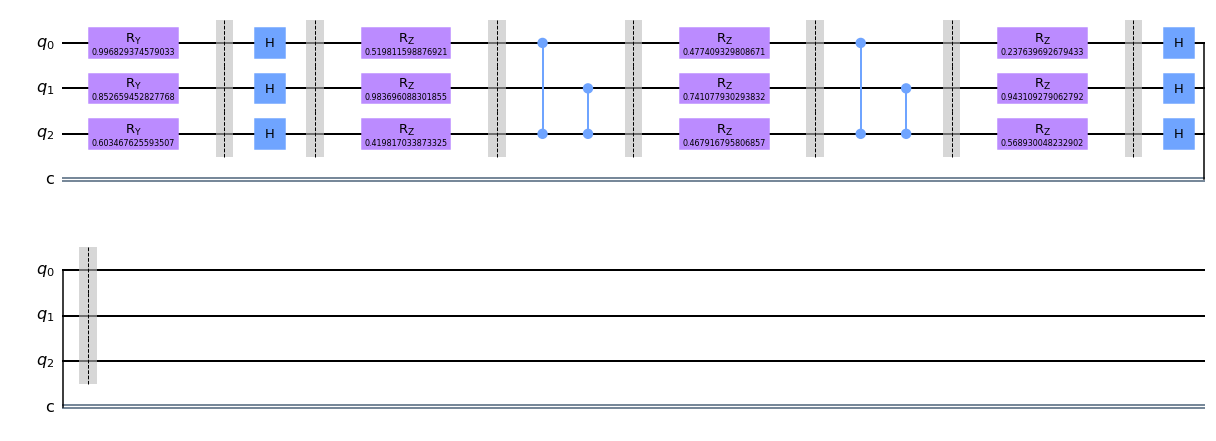

In [5]:
vqc(n,num_layers,x_train[0],params).draw()

In [6]:
from scipy.optimize import minimize ## need the mthod minimize of scipy.optimize module

def calc_cost(real_value, circuit_value):
    diff = 0
    for i in range(len(real_value)):
        diff += (real_value[i] - circuit_value[i])**2       ## calculates the sum of squares 
    mod_abs = diff.real**2 + diff.imag**2   ## of mod of difference between corresponding elements 
    cost = np.sum(mod_abs)                  ## of real_value and circuit_value
    return cost                             ## returns the cost

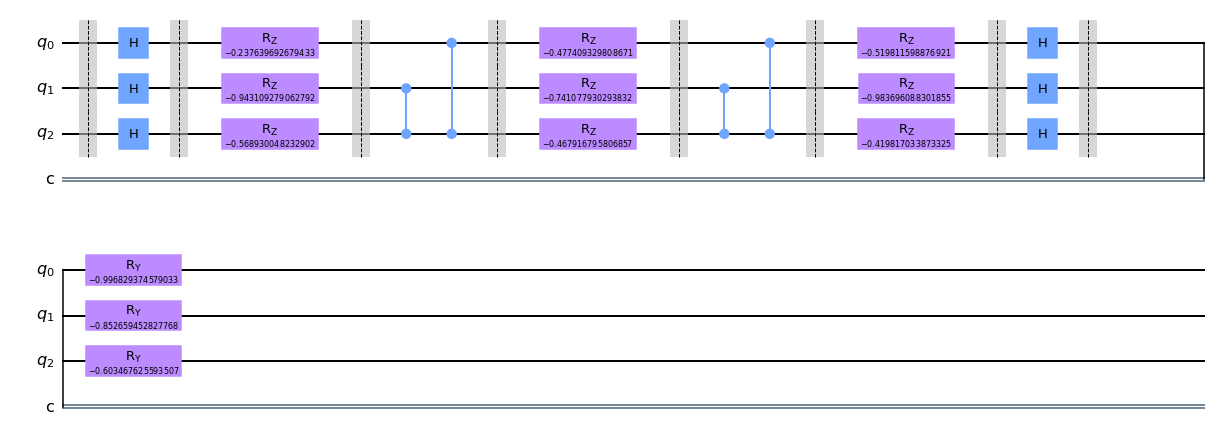

In [7]:
vqc(n,num_layers,x_train[0],params).inverse().draw()

In [8]:
def objective_function(params):
    y_pred = []
    for i in range(len(x_train)):
        qc = vqc(n,num_layers,x_train[i],params)
        out = n-1
        qc.measure(out, 0)
        #qc.draw()
        job = execute( qc, Aer.get_backend('qasm_simulator') )
        result = job.result().get_counts()
        
        try:
            y_pred.append(result['1']/1024)
        except:
            y_pred.append(0)

    return calc_cost(y_train,y_pred)

    
minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
params = minimum.x
print("params: ",params, "  cost: ",objective_function(params))

params:  [0.52019144 1.97811647 0.42460734 0.4794165  0.74179344 0.46927678
 0.23758667 0.94347004 0.56947619]   cost:  77.79554189780704


In [9]:
y_pred = []
for i in range(len(y_train)):
    qc = vqc(n,num_layers,x_train[i],params)
    out = n-1
    qc.measure(out, 0)
    #qc.draw()
    job = execute( qc, Aer.get_backend('qasm_simulator') )
    result = job.result().get_counts()
    y_pred.append(result['0']/1024)
    print(y_pred[i],y_train[i])

0.5546875 0.4171993317697382
0.564453125 0.6050014465101912
0.55078125 0.6085805444643901
0.5498046875 0.038103921663554585
0.53515625 0.3453410932569869
0.53515625 0.13344617596375963
0.5595703125 0.6099128085720179
0.58203125 0.04921619736246774
0.56640625 0.5519457558664586
0.5146484375 0.48907086591529736
0.529296875 0.6128502168633191
0.564453125 0.7407056927555544
0.5322265625 0.72229823407762
0.5341796875 0.20096780543978787
0.54296875 0.39630479147227593
0.5458984375 0.3385007828000284
0.5380859375 0.26341350945061326
0.5751953125 0.6078513678169053
0.55078125 0.4928806389498791
0.572265625 0.11475630025529637
0.5341796875 0.45672169437012955
0.5341796875 0.03537185686565647
0.533203125 0.2097418145452955
0.541015625 0.20640705167743434
0.5361328125 0.9434888210425523
0.541015625 0.011712415585575675
0.5576171875 0.0934027785122139
0.576171875 0.11086125580057882
0.5478515625 0.1363511209208672
0.5625 0.9002809362425814
0.5107421875 0.025513817081312395
0.56640625 0.62090887466

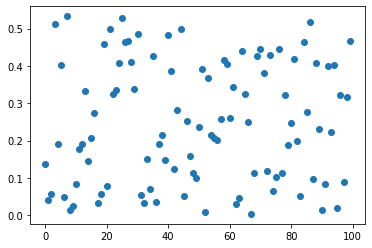

In [10]:
import matplotlib.pyplot as plt
g=plt.plot(abs(y_train - y_pred),marker='o',linestyle='')


In [11]:
x_axis = [i for i in range(1,101)]

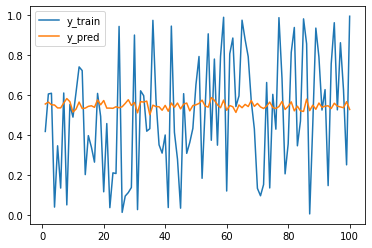

In [12]:
plt.plot(x_axis, y_train, label='y_train')
plt.plot(x_axis, y_pred, label='y_pred')
plt.legend()

In [13]:
from sklearn.metrics import mean_absolute_error
errors = mean_absolute_error(y_train, y_pred)
print(errors)

0.2482907274651964


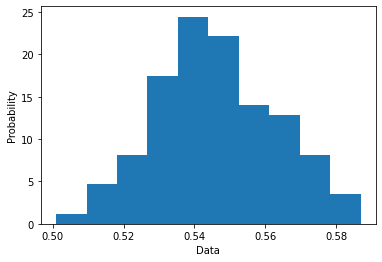

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.hist(y_pred, density=True, bins=10)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

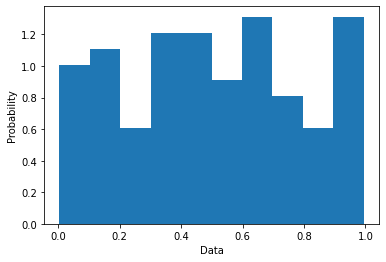

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.hist(y_train, density=True, bins=10)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');